In [1]:
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from tqdm.auto import tqdm, trange

/bg/fast/env_wiegels-r/mambaforge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RADKLIM YW DATA
ds_yw_all = xr.open_dataset('/pd/data/CML/temp_radklim/RADKLIM_YW2017.002_2020.nc')
# choose needed time period
ds_yw= ds_yw_all.sel(time=slice('2020-06-01T00:15:00', '2020-07-01T00:00:00'))

In [4]:
%%time
# change resolution of time (5min -> 15min) 
ds_yw_15min = ds_yw.resample(time='15min', label='left', skipna=False).sum(skipna=False) ## --> returns label of left side: e.g.12:00 - 12:15 returns label 12:00
ds_yw_15min

CPU times: user 1min 34s, sys: 20.1 s, total: 1min 54s
Wall time: 1min 56s


<xarray.Dataset>
Dimensions:          (time: 2976, x: 900, y: 1100)
Coordinates:
  * time             (time) datetime64[ns] 2020-10-01T00:15:00 ... 2020-11-01
  * x                (x) float64 -443.5 -442.5 -441.5 ... 453.5 454.5 455.5
  * y                (y) float64 -4.759e+03 -4.758e+03 ... -3.661e+03 -3.66e+03
    latitudes        (y, x) float64 46.19 46.19 46.19 46.2 ... 55.53 55.53 55.53
    longitudes       (y, x) float64 4.676 4.688 4.7 4.712 ... 17.06 17.08 17.1
Data variables:
    rainfall_amount  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    maxrange         (time) int64 450 450 450 450 450 ... 450 450 450 450 150
    radolan_grid     (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36

## Spatial Resolution: interpolate to SEVIRIs grid

In [5]:

def interpol2highres(ds_yw, LON_grid, LAT_grid, ts):

    # points that have to interpolate from
    yw_lat_flat = ds_yw.latitudes.values.flatten()
    yw_lon_flat = ds_yw.longitudes.values.flatten()
    # points that need interpolation
    rainfall_flat = ds_yw.rainfall_amount.isel(time=ts).values.flatten()
    # interpolation process
    rainfall_interp = scipy.interpolate.griddata((yw_lon_flat, yw_lat_flat), rainfall_flat, (LON_grid, LAT_grid), method='linear')

    return rainfall_interp

In [6]:
# open seviri grid
old_seviri = xr.open_dataset('/pd/home/wiegels-r/test/msg_seviri_wet_dry/data/ds_seviri_cut.nc')
old_seviri

<xarray.Dataset>
Dimensions:     (time: 2970, y: 180, x: 252)
Coordinates:
  * time        (time) datetime64[ns] 2021-05-01T00:15:00 ... 2021-06-01
    LON         (y, x) float64 ...
    LAT         (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables: (12/13)
    IR_016      (time, y, x) float64 ...
    IR_039      (time, y, x) float64 ...
    IR_087      (time, y, x) float64 ...
    IR_097      (time, y, x) float64 ...
    IR_108      (time, y, x) float64 ...
    IR_120      (time, y, x) float64 ...
    ...          ...
    VIS006      (time, y, x) float64 ...
    VIS008      (time, y, x) float64 ...
    WV_062      (time, y, x) float64 ...
    WV_073      (time, y, x) float64 ...
    longitudes  (y, x) float64 ...
    latitudes   (y, x) float64 ...

In [7]:
# LAT_grid, LON_grid = highres_grid(factor=1, ds_seviri=old_seviri) # since we are not using a higher resolution grid we can skip this step and directly interpolate to LAT, LON grid of SEVIRI
LAT_grid = old_seviri.LAT.values
LON_grid = old_seviri.LON.values

array([[45.95974076, 45.96016767, 45.96059913, ..., 46.21243897,
        46.21408059, 46.21572761],
       [46.00727028, 46.0076984 , 46.0081311 , ..., 46.26070909,
        46.26235565, 46.26400763],
       [46.05486225, 46.05529161, 46.05572555, ..., 46.30904549,
        46.31069701, 46.31235396],
       ...,
       [55.70327764, 55.70409411, 55.70491937, ..., 56.19905173,
        56.20236143, 56.20568326],
       [55.7690171 , 55.76983761, 55.77066694, ..., 56.26738842,
        56.27071651, 56.27405682],
       [55.83493037, 55.83575495, 55.83658841, ..., 56.33592556,
        56.33927225, 56.34263123]])

In [7]:
%%time
results = []
for ts in tqdm(range(0, len(ds_yw_15min_1.time))):
               ds_interp = interpol2highres(ds_yw_15min_1, LON_grid, LAT_grid, ts=ts)
               results.append(ds_interp)
result = np.asarray(results)
result

100%|████████████████████████████████████████████████████████████████████████████| 2880/2880 [13:29:01<00:00, 16.85s/it]


CPU times: user 17h 48min 10s, sys: 3h 51min 13s, total: 21h 39min 24s
Wall time: 13h 29min 2s


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

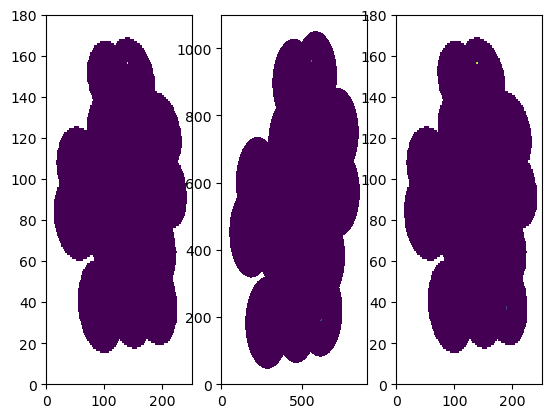

In [45]:
fig, ax = plt.subplots(1,3)
ax[0].pcolormesh(ds_interp)
ax[1].pcolormesh(ds_yw_15min.isel(time=0).rainfall_amount)
ax[2].pcolormesh(result_0[0])
plt.show()

## Save interpolated RADKLIM data to netCDF

In [10]:
pd_range = pd.date_range(start='2020-06-01T00:15:00.000000000', end='2020-07-01T00:00:00.000000000', freq='15min')
len(pd_range)

2880

In [11]:
# 3. Save interpolated RADKLIM data into netCDF
ds_yw_interp = xr.Dataset(
    data_vars={
    'rainfall_amount': xr.DataArray(
        data = result_0,
        dims = ['time', 'y', 'x'],
        coords = {'time': pd_range}
    )}, 
    coords={
     'LON':xr.DataArray(
        data = LON_grid,
        dims = ['y', 'x'],
    ),
    'LAT':xr.DataArray(
        data = LAT_grid,
        dims = ['y', 'x']
    )
                           
})
print(ds_yw_interp)
ds_yw_interp

<xarray.Dataset>
Dimensions:          (time: 2880, y: 180, x: 252)
Coordinates:
  * time             (time) datetime64[ns] 2020-06-01T00:15:00 ... 2020-07-01
    LON              (y, x) float64 3.839 3.88 3.921 3.962 ... 18.36 18.42 18.47
    LAT              (y, x) float64 45.96 45.96 45.96 ... 56.34 56.34 56.34
Dimensions without coordinates: y, x
Data variables:
    rainfall_amount  (time, y, x) float64 nan nan nan nan ... nan nan nan nan


<xarray.Dataset>
Dimensions:          (time: 2880, y: 180, x: 252)
Coordinates:
  * time             (time) datetime64[ns] 2020-06-01T00:15:00 ... 2020-07-01
    LON              (y, x) float64 3.839 3.88 3.921 3.962 ... 18.36 18.42 18.47
    LAT              (y, x) float64 45.96 45.96 45.96 ... 56.34 56.34 56.34
Dimensions without coordinates: y, x
Data variables:
    rainfall_amount  (time, y, x) float64 nan nan nan nan ... nan nan nan nan

In [17]:
ds_yw_interp.to_netcdf('data/ds_yw_202006')

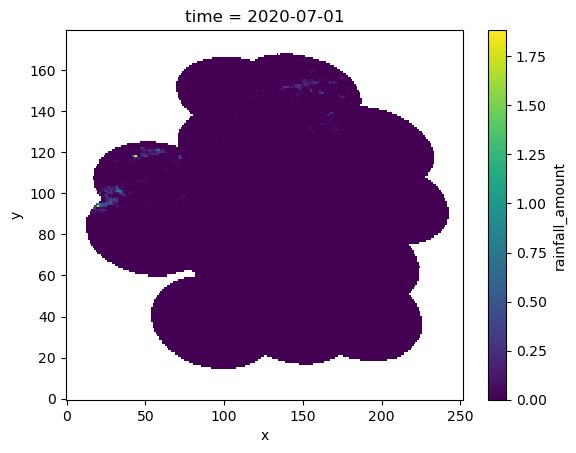

In [14]:
ds_yw_interp.isel(time=2879).rainfall_amount.plot()